In [1]:
from GameForCNN import Tribounce

from gymnasium import Env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt 

from gymnasium.spaces import Discrete,Box

import os
import cv2

pygame 2.5.0 (SDL 2.28.0, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class TribounceEnv(Env):
    def __init__(self,render=False,gray=True):
        super().__init__()
        self.game = Tribounce(render=render)
        self.gray = gray
        self.observation_space = Box(low=0,high=255,shape=(119,170,1),dtype=np.uint8)
        self.action_space = Discrete(3)

    def step(self,action):
        state,reward,done,info = self.game.run(action=action)
        if self.gray:
            state = self.grayscale(state)
        truncated = False
        return state,reward,truncated,done,info
    
    def render(self):
        pass
    
    def reset(self,seed=0):
        state = self.game.reset()
        state = self.grayscale(state)
        info = {}
        return state,info
    
    def grayscale(self,state):
        gray = cv2.cvtColor(np.float32(state),cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray,(170,119),interpolation=cv2.INTER_CUBIC)
        
        state = np.reshape(resize.astype(np.uint8),(119,170,1))
        return state
    
    def close(self):
        self.game.close()


In [3]:
env = TribounceEnv()
env.step(2)[0]

array([[[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [ 10],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]],

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]],

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]]], dtype=uint8)

In [3]:
from stable_baselines3.common import env_checker

In [4]:
env = TribounceEnv()
env_checker.check_env(env)

In [6]:
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [ 10],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]],

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]],

       [[190],
        [190],
        [190],
        ...,
        [190],
        [190],
        [190]]], dtype=uint8)

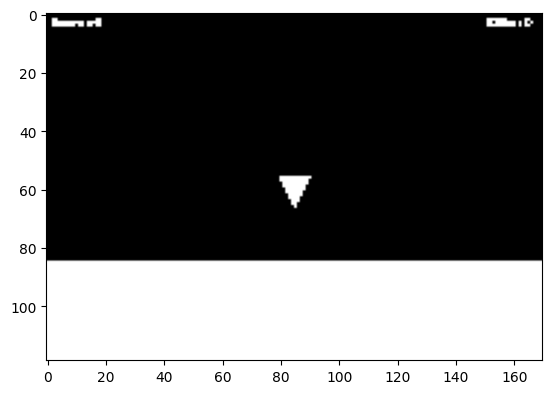

In [7]:
state = env.step(2)[0]
img = plt.imshow(cv2.cvtColor(np.float32(state),cv2.COLOR_BGR2RGB))
state

In [5]:
episodes = 2
env = TribounceEnv(render=True,gray=False)
for episode in range(1,episodes+1):
    state,_ = env.reset()
    done = False
    while not done:
        action = Discrete(3).sample()
        state,reward,_,done,info = env.step(action=action)
    print(f"Episode:({episode}) Score:({info['score']}) Reward:({reward})")
env.close()

Episode:(1) Score:(14) Reward:(-3736)
Episode:(2) Score:(5) Reward:(-53)


In [9]:
env.close()

In [3]:
# Thanks Nicholas :

class TrainAndLoggingCallBack(BaseCallback):
    def __init__(self,check_freq,save_path, verbose=1):
        super(TrainAndLoggingCallBack,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,f'best_model_{self.n_calls}')
            self.model.save(model_path)
        return True

In [4]:
check_point_dir = './train/train_basic'
log_dir = './logs/log_basic'

In [5]:
callback = TrainAndLoggingCallBack(check_freq=50000,save_path=check_point_dir)

In [6]:
##### TRAINING THE MODEL

env = TribounceEnv()

In [7]:
model = PPO('CnnPolicy',env,verbose=1,tensorboard_log=log_dir,learning_rate=0.0001,n_steps=2048,)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [8]:
model.learn(total_timesteps=200000,callback=callback)

Logging to ./logs/log_basic\PPO_8


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 962       |
|    ep_rew_mean     | -2.57e+05 |
| time/              |           |
|    fps             | 46        |
|    iterations      | 1         |
|    time_elapsed    | 44        |
|    total_timesteps | 2048      |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 647       |
|    ep_rew_mean          | -3.68e+05 |
| time/                   |           |
|    fps                  | 45        |
|    iterations           | 2         |
|    time_elapsed         | 90        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 11.645752 |
|    clip_fraction        | 0.688     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.396    |
|    explained_variance   | -2.15e-06 |
|    learning_rate        | 0.0001    |
|    loss 

KeyboardInterrupt: 

In [9]:
model = PPO.load("train\\train_basic\\best_model_100000.zip")

In [10]:
env= TribounceEnv(render=True)
evaluate_policy(model,env,n_eval_episodes=5)
env.close()


c:\Users\arya2\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
env.close()

In [11]:
episodes = 5
env = TribounceEnv(render=True)
for episode in range(1,episodes+1):
    state,_ = env.reset()
    done = False
    while not done:
        action,_ = model.predict(state)
        state,reward,_,done,info = env.step(action=action)
    print(f"Episode:({episode}) Score:({info['score']}) Reward:({reward})")
env.close()

Episode:(1) Score:(1) Reward:(-558)
Episode:(2) Score:(0) Reward:(0)
Episode:(3) Score:(0) Reward:(0)
Episode:(4) Score:(0) Reward:(0)
Episode:(5) Score:(0) Reward:(0)
